<a href="https://colab.research.google.com/github/Nazneen-akram/healthcare-insurance-fraud/blob/main/initial_EDA_Fraud_Claims_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split

#Functions to join Dataset
##**'Beneficiary'**, **'Inpatient'**, **'Outpatient'** and **'Fraud'** into **'merged.csv'**

1.   **join_inpatient_outpatient():** : Function to merge inpatient, outpatient dataframe
2.   **join_inpatient_outpatient_beneficiary()**: Function to merge merged df, beneficiary dataframe
3. **join_inpatient_outpatient_beneficiary_fraud()**: Function to merge merged df, fraud dataframe
4. **join_csv()**: Function to join csv files. Joining by key BeneID, Provider.
5. **generate_merged_data()**: mainfunction to join csv files. calls read_data and join_csv functions



In [2]:
def read_data():
    """
    function to read csv files
    parameters: None
    return: data frames fraud, beneficiary, inpatient, outpatient.
    raise FileExistsError: raises an exception when file is not found
    """
    try:
        fraud=pd.read_csv("/content/Train-1542865627584.csv")
        beneficiary=pd.read_csv("/content/Train_Beneficiarydata-1542865627584.csv")
        inpatient=pd.read_csv("/content/Train_Inpatientdata-1542865627584.csv")
        outpatient=pd.read_csv("/content/Train_Outpatientdata-1542865627584.csv")
        return fraud, beneficiary, inpatient, outpatient
    except FileExistsError as error:
        raise error

In [5]:
def join_inpatient_outpatient(inpatient, outpatient):
    """
    function to merge inpatient, outpatient dataframe
    parameters: inpatient, outpatient
    return: merged dataframe
    """
    inpatient['is_Inpatient'] = 1
    outpatient['is_Inpatient'] = 0
    inpatient_outpatient = pd.concat([inpatient,outpatient])
    return inpatient_outpatient


def join_inpatient_outpatient_beneficiary(inpatient_outpatient, beneficiary):
    """
    function to merge merged df, beneficiary dataframe
    parameters: inpatient, outpatient merged and beneficiary
    return: merged dataframe
    """
    inpatient_outpatient_beneficiary=pd.merge(inpatient_outpatient,beneficiary,
                                left_on='BeneID',right_on='BeneID',how='inner')
    return inpatient_outpatient_beneficiary


def join_inpatient_outpatient_beneficiary_fraud(inpatient_outpatient_beneficiary, fraud):
    """
    function to merge merged df, fraud dataframe
    parameters: inpatient, outpatient merged, beneficiary and fraud
    return: merged dataframe
    """
    inpatient_outpatient_beneficiary_fraud=pd.merge(fraud,inpatient_outpatient_beneficiary,
                                                    on='Provider')
    return inpatient_outpatient_beneficiary_fraud


def join_csv(fraud, beneficiary, inpatient, outpatient):
    """
    function to join csv files. Joining by key BeneID, Provider.
    parameters: fraud, beneficiary, inpatient, outpatient dataframes
    return: merged csv
    """
    # Join the files
    merged = join_inpatient_outpatient(inpatient, outpatient)
    merged = join_inpatient_outpatient_beneficiary(merged, beneficiary)
    merged = join_inpatient_outpatient_beneficiary_fraud(merged, fraud)

    # Save the merged file as a CSV
    merged.to_csv('/content/merged.csv', index=False)


def generate_merged_data():
    """
    mainfunction to join csv files. calls read_data and join_csv functions
    parameters: None
    return: None
    """
    fraud, beneficiary, inpatient, outpatient = read_data()
    join_csv(fraud, beneficiary, inpatient, outpatient)



In [6]:
generate_merged_data()

In [7]:
def read_data():
    """
    function to read csv file
    parameters: None
    return: data frames fraud, beneficiary, inpatient, outpatient.
    raise FileExistsError: raises an exception when file is not found
    """
    try:
        merged = pd.read_csv("/content/merged.csv",low_memory=False)
    except FileExistsError as error:
        raise error
    return merged

##Module to perform data preprocesssing. This will be first level preprocessing. For visualization
##and machine learning modeling seperate preprocessing will be required according to the requirements.

In [8]:
def encoding_potential_fraud(dataframe):
    """
    function encode catagorical field having yes/no into a numerical field
    parameters: merged dataset
    return: modified dataframe with potencialfraud encoded into numerical value
    """
    dataframe['PotentialFraud'] = dataframe['PotentialFraud'].map({'Yes': 1, 'No': 0})
    # corr_to_target = dataframe.corr()['PotentialFraud'].abs().sort_values(ascending=False)
    return dataframe


def encode_categorical_data(dataframe):
    """
    Encode categorical fields with 'yes/no' into numerical fields.

    Parameters:
    - df: DataFrame to process.

    Returns:
    - DataFrame with categorical columns encoded into numerical values.
    """

    # Assuming '2' should be replaced with '0' for the specified chronic conditions.
    chronic_conditions = [
        'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
        'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
        'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
        'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke'
    ]
    for condition in chronic_conditions:
        dataframe[condition] = dataframe[condition].replace(2, 0)

    # Replace 'Y' with '1' for 'RenalDiseaseIndicator'.
    dataframe['RenalDiseaseIndicator'] = dataframe['RenalDiseaseIndicator'].replace('Y', 1)

    return dataframe



def add_admit_column(dataframe):
    """
    function to add a column admitdays
    parameters: merged dataset
    return: modified dataframe with added admitfordays column
    """
    dataframe['AdmissionDt'] = pd.to_datetime(dataframe['AdmissionDt'], format='%Y-%m-%d')
    dataframe['DischargeDt'] = pd.to_datetime(dataframe['DischargeDt'], format='%Y-%m-%d')
    dataframe['AdmitForDays'] = ((dataframe['DischargeDt'] - dataframe['AdmissionDt']).dt.days) + 1
    return dataframe


def add_age_column(dataframe):
    """
    function to add a column age based on DOB and DOD
    parameters: merged dataset
    return: modified dataframe with added age column
    """
    dataframe['DOB'] = pd.to_datetime(dataframe['DOB'], format='%Y-%m-%d')
    dataframe['DOD'] = pd.to_datetime(dataframe['DOD'], format='%Y-%m-%d', errors='ignore')
    dataframe['Age'] = round(((dataframe['DOD'] - dataframe['DOB']).dt.days) / 365)
    dataframe.Age.fillna(round(((pd.to_datetime('2009-12-01', format='%Y-%m-%d') -
                                 dataframe['DOB']).dt.days) / 365),
                         inplace=True)

    dataframe.Age.fillna(round(((pd.to_datetime('2009-12-01', format='%Y-%m-%d') -
                                 dataframe['DOB']).dt.days) / 365),
                         inplace=True)
    return dataframe


def adding_dead_column(dataframe):
    """
    function to add a column to get if the person is dead or not
    parameters: merged dataset
    return: modified dataframe with added WhetherDead column
    """
    dataframe.loc[dataframe.DOD.isna(), 'WhetherDead'] = 0
    dataframe.loc[dataframe.DOD.notna(), 'WhetherDead'] = 1
    dataframe.loc[:, 'WhetherDead'].head(7)
    return dataframe


In [9]:


def create_columns_visualization(dataframe, state_mapping):
    """
    Adds columns to indicate patient status, age, state, admission duration, and insurance claim reimbursement buckets.

    Parameters:
    - df: The input DataFrame.
    - state_mapping: DataFrame containing state mappings.

    Returns:
    - DataFrame with new columns added.
    """
    # Filter for inpatient records
    inpatient_final_df = dataframe.loc[dataframe['is_Inpatient'] ==1]

    # Convert date columns to datetime format
    inpatient_final_df['ClaimStartDt'] = inpatient_final_df['ClaimStartDt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    inpatient_final_df['ClaimEndDt'] = inpatient_final_df['ClaimEndDt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

    # Calculate age based on a fixed date
    inpatient_final_df['Age'] = inpatient_final_df['DOB'].apply(lambda x: datetime.strptime("2013-03-03", '%Y-%m-%d').year - x.year)


    # Merge with state mapping
    inpatient_final_df = inpatient_final_df.merge(state_mapping, on ='State', how = 'left')

    # Admission day buckets
    inpatient_final_df['Days_Admitted_Bucket'] = inpatient_final_df['AdmitForDays'].apply(lambda x: "0-20 Days" if x <= 20 else "More than 20 Days")

    # Insurance claim amount reimbursement buckets
    def reimbursement_bucket(x):
        if x <= 20000:
            return '0 - 20000'
        elif 20000 < x <= 40000:
            return '20000 - 40000'
        elif 40000 < x <= 60000:
            return '40000 - 60000'
        else:
            return 'Greater than 60000'

    inpatient_final_df['InscClaimAmtReimbursed_Bucket'] = inpatient_final_df['InscClaimAmtReimbursed'].apply(reimbursement_bucket)

    return inpatient_final_df


def save_csv(dataframe):
    """
    function to save preprocessed data into a csv file, to be used for further
    computations of the project.
    parameters: merged dataset
    return: None
    """
    dataframe.to_csv('/content/preprocessed.csv', index=False)


def save_test_data(x_test,y_test):
    """
    function to save test data into a csv file, to be used for further
    computations of the project.
    parameters: merged dataset
    return: None
    """
    x_test.to_csv('/content/test.csv', index=False)
    y_test.to_csv('/content/test_labels.csv', index=False)


def pre_processing():
    """
    function to read and then preprocess data
    parameters: merged dataset
    return: modified dataframe with added WhetherDead column
    """
    dataframe = read_data()
    dataframe = encode_categorical_data(dataframe)
    dataframe = add_admit_column(dataframe)
    dataframe = add_age_column(dataframe)
    dataframe = adding_dead_column(dataframe)
    dataframe = encoding_potential_fraud(dataframe)
    return dataframe


In [10]:
def main_processing():
    """
    Main function to preprocess data, create visualizations, split data into training and testing sets,
    and save processed data to CSV.
    """
    # Preprocess data and save initial CSV
    dataframe = pre_processing()
    save_csv(dataframe)

    # Load state mapping and create visualization data
    state_mapping = pd.read_csv("/content/State_Mapping.csv")
    viz_df = create_columns_visualization(dataframe, state_mapping)
    viz_df.to_csv('/content/visualization.csv', index=False)

    # Split data into features and labels
    features, labels = dataframe.drop("PotentialFraud", axis=1), dataframe['PotentialFraud']

    # Train-test split
    x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state=1, test_size=0.10, shuffle=True)

    # Process training data
    training_data = process_data(x_train, y_train, '/content/training_data.csv')

    # Process testing data
    test_data = process_data(x_test, y_test, '/content/testing_data.csv', is_train=False)

def process_data(x, y=None, filepath='/content/data.csv', is_train=True):
    """
    Process data by selecting numeric types, filling NA values, and optionally concatenating labels.

    Parameters:
    - x: Features DataFrame.
    - y: Labels Series (optional).
    - filepath: Path to save processed data.
    - is_train: Boolean indicating if the data is training data.

    Returns:
    - Processed DataFrame.
    """
    # Select numeric columns and fill NA values
    x_numeric = x.select_dtypes(exclude=['object', 'datetime64[ns]']).fillna(0)

    if is_train:
        # Concatenate labels for training data
        dataframe = pd.concat([x_numeric, y], axis=1)
    else:
        dataframe = x_numeric

    # Save processed data to CSV
    dataframe.to_csv(filepath, index=False)
    return dataframe


In [13]:
main_processing()

<ipython-input-9-e165225e2615>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpatient_final_df['ClaimStartDt'] = inpatient_final_df['ClaimStartDt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
<ipython-input-9-e165225e2615>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpatient_final_df['ClaimEndDt'] = inpatient_final_df['ClaimEndDt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
<ipython-input-9-e165225e2615>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

##Initial EDA After Pre-processing
###Module to perform initial eda on merged dataset to get
###initial idea about the dataset for preprocessing and further computations.
###imports: numpy, pandas

In [14]:
def read_data():
    """
    function to read csv file
    parameters: None
    return: data frames fraud, beneficiary, inpatient, outpatient.
    raise FileExistsError: raises an exception when file is not found
    """
    try:
        merged=pd.read_csv("/content/preprocessed.csv")
    except FileExistsError as error:
        raise error
    return merged

def get_unique_values(dataframe):
    """
    function to get unique values of dataframe
    parameters: merged dataset
    return: None
    """
    unique_vals = dataframe.nunique().sort_values()
    print("Number of unique values:\n", unique_vals)


def get_dimention(dataframe):
    """
    function to get number of rows and columns, all columns, to show first 5 data.
    parameters: merged dataset
    return: None
    """
    print(dataframe.describe())
    print("Number of rows and columns:", dataframe.shape)
    print("\nColumn names:\n", dataframe.columns)
    print("\nFirst  rows:\n", dataframe.head())


def get_missing_data(dataframe):
    """
    function to prints the percentage of missing values in each column.
    parameters: merged dataset
    return: None
    """
    total_missing = dataframe.isnull().sum().sort_values(ascending=False)
    percent_missing = (total_missing / len(dataframe)) * 100
    missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
    print("Percentage of missing values:\n", missing_data)


def plot_heatmap(dataframe):
    """
    function to plot heat map
    parameters: merged dataset
    return: None
    """
    corr = dataframe.corr(numeric_only=True)
    # Set correlations less than 0.4 and greater than -0.4 to NaN so they aren't plotted
    corr[corr.abs() < 0.4] = None
    plt.figure(figsize=(16, 16))
    # Use sns.heatmap with a modified 'corr' that excludes low correlations
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Correlation Heatmap")
    plt.show()


def plot_boxplots(dataframe, columns):
    """
    function to plot boxplots
    parameters: merged dataset, columns for which we want to plot
    return: None
    """
    for column in columns:
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='PotentialFraud', y=column, data=dataframe)
        plt.title(f"{column} by PotentialFraud")
        plt.show()


def get_admit_analysis(dataframe):
    """
    function to get range of admitdays
    parameters: merged dataset, columns for which we want to plot
    return: None
    """
    # Lets check Min and Max values of AdmitforDays column in Train and Test.
    print('Min Admit:- ',dataframe.AdmitForDays.min())
    print('Max Admit:- ',dataframe.AdmitForDays.max())
    dataframe.AdmitForDays.isnull().sum()   #Check Null values.

def get_correlation(dataframe):
    """
    function get correlation
    parameters: merged dataset
    return: top 5 columns having highest correlation with PotentialFraud
    """
    corr_to_target = dataframe.corr(numeric_only=True)['PotentialFraud'].abs().sort_values(ascending=False)
    return corr_to_target[1:6].index


def age_distribution(dataframe):
    """
    Function to display the age distribution of patients using seaborn's histplot.

    Parameters:
    - dataframe: Preprocessed dataset with an 'Age' column.

    Returns:
    - Displays a histogram of the age distribution.
    """
    label_font_dict = {'fontsize': 12, 'fontweight': 'bold'}
    title_font_dict = {'fontsize': 14, 'fontweight': 'bold'}

    with plt.style.context('seaborn'):
        plt.figure(figsize=(10,8))
        sns.histplot(dataframe['Age'], color='purple', bins=20)  # Using seaborn's histplot
        # Providing the labels and title to the graph
        plt.xlabel("\nBeneficiaries Age in years", fontdict=label_font_dict)
        plt.ylabel("Frequency of patients\n", fontdict=label_font_dict)
        plt.grid(which='major', linestyle="--", color='lightgrey')
        plt.minorticks_on()
        plt.title("Distribution of Beneficiaries' Age", fontdict=title_font_dict)
        plt.legend(["Age Distribution"])
        plt.show()  # Display the plot


def get_eda():
    """
    function get complete eda
    parameters: None
    return: None
    """
    merged = read_data()
    saved = merged
    get_unique_values(merged)
    get_dimention(merged)
    get_missing_data(merged)
    get_admit_analysis(merged)
    plot_heatmap(merged)
    age_distribution(merged)
    top_5_corr = get_correlation(merged)
    plot_boxplots(saved, top_5_corr)


Number of unique values:
 ClmProcedureCode_6                      0
Gender                                  2
RenalDiseaseIndicator                   2
ChronicCond_Alzheimer                   2
ChronicCond_Heartfailure                2
ChronicCond_KidneyDisease               2
ChronicCond_Cancer                      2
is_Inpatient                            2
WhetherDead                             2
ChronicCond_Diabetes                    2
ChronicCond_IschemicHeart               2
ChronicCond_Osteoporasis                2
ChronicCond_rheumatoidarthritis         2
ChronicCond_stroke                      2
PotentialFraud                          2
ChronicCond_Depression                  2
ChronicCond_ObstrPulmonary              2
Race                                    4
ClmProcedureCode_5                      6
DOD                                    11
NoOfMonths_PartACov                    12
NoOfMonths_PartBCov                    13
DeductibleAmtPaid                      14
AdmitFor

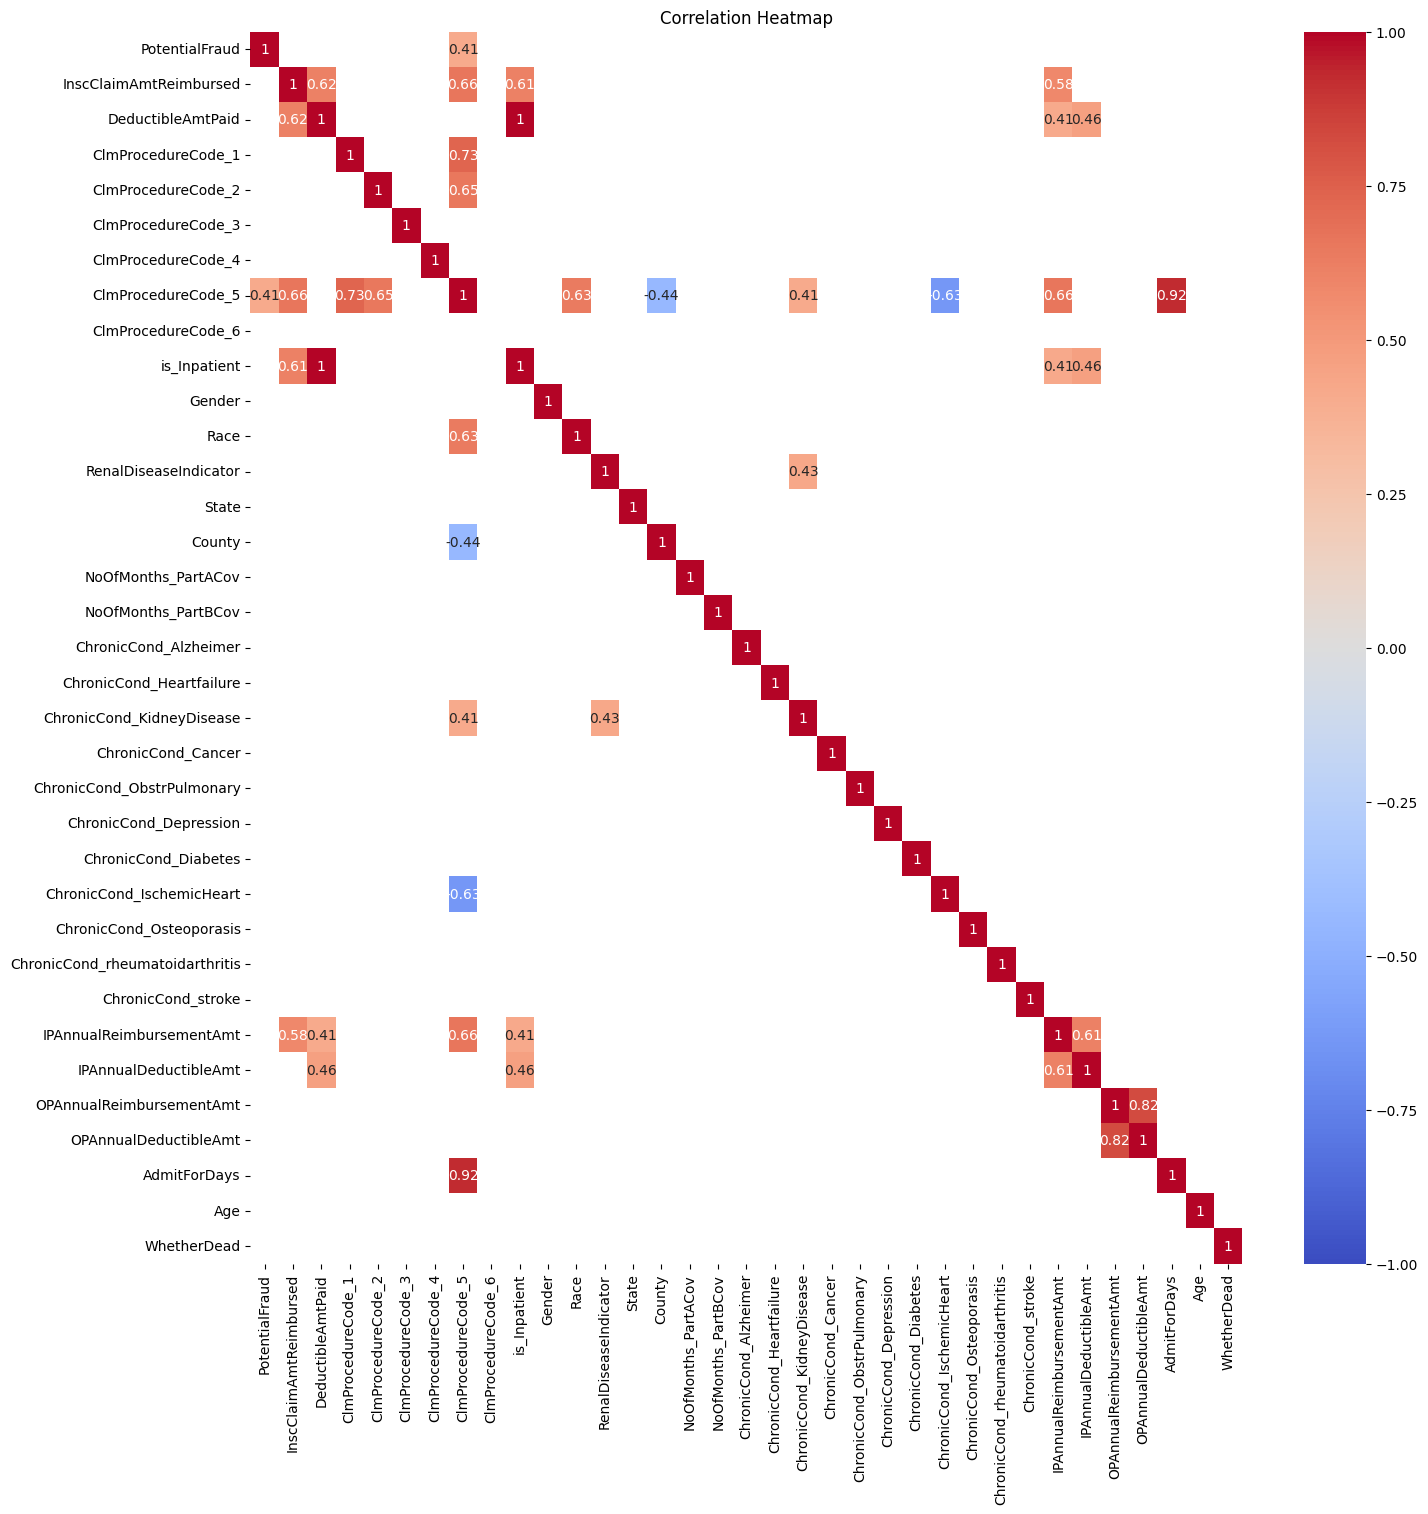

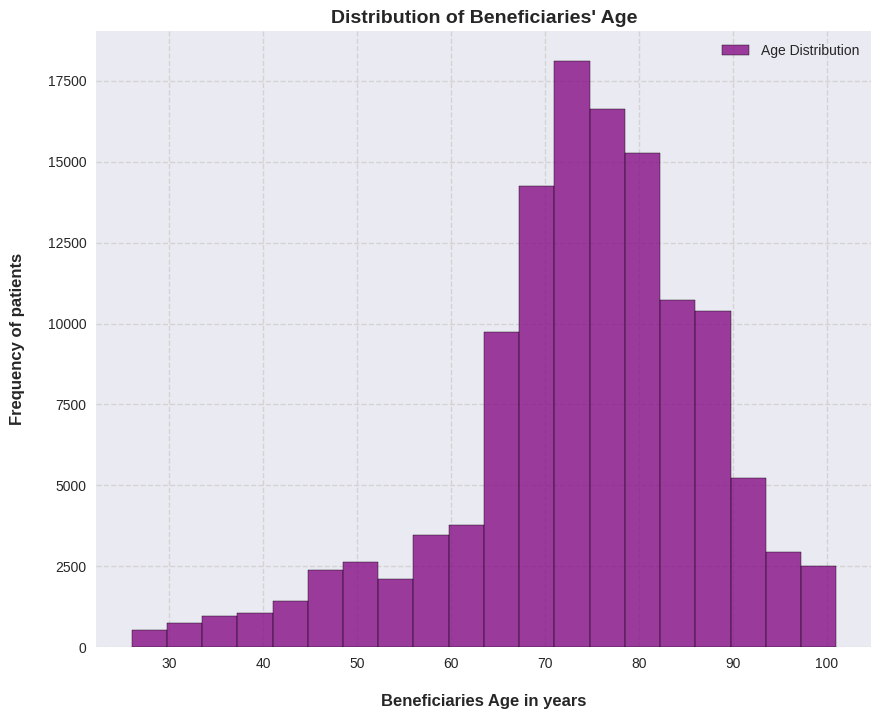

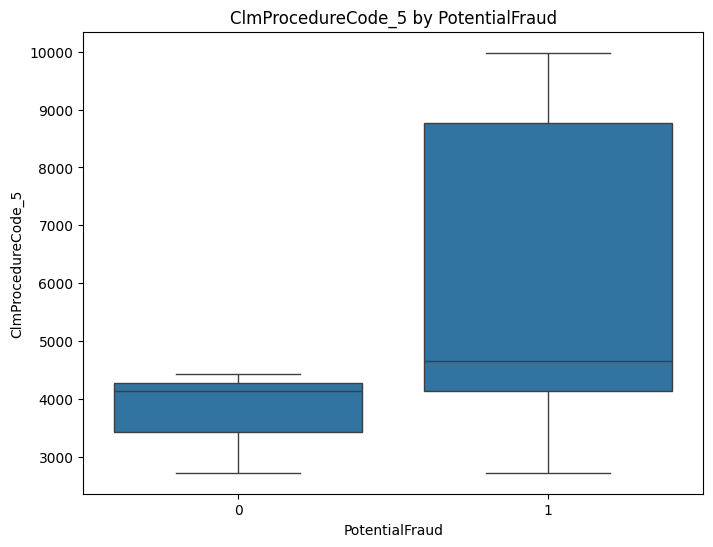

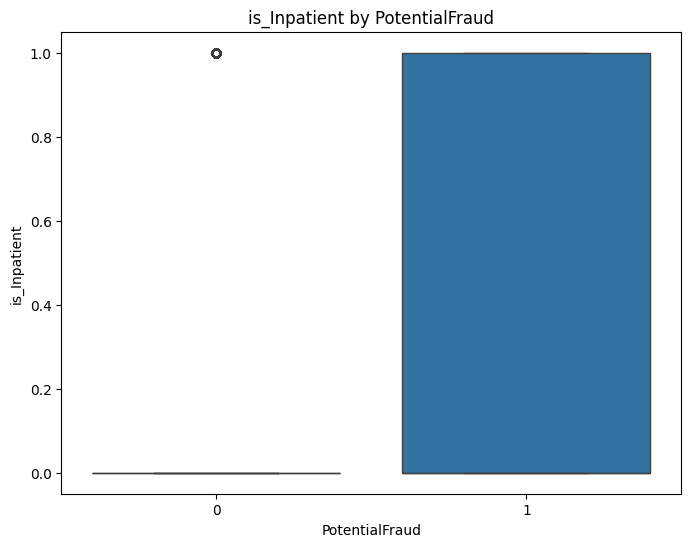

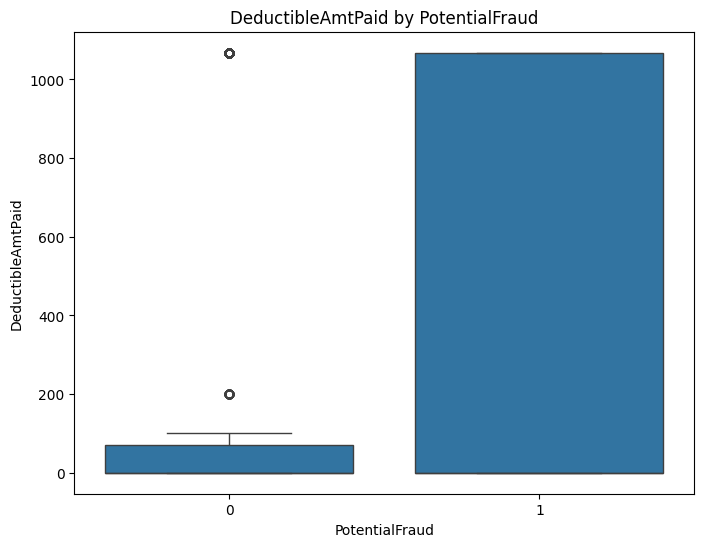

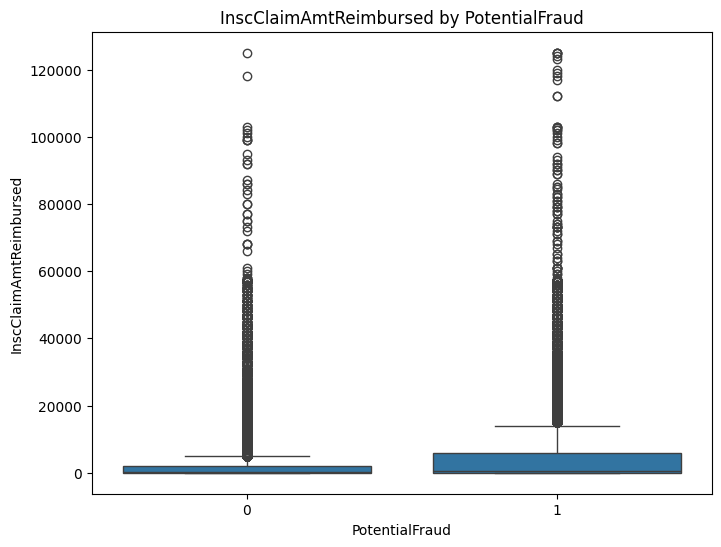

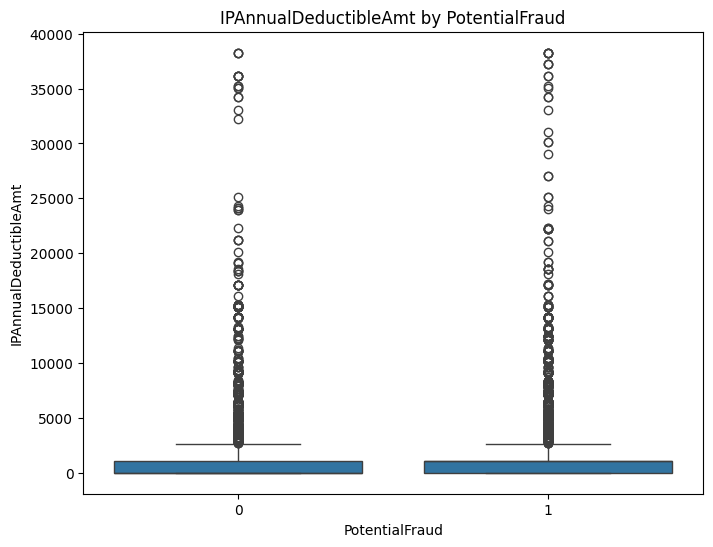

In [15]:
get_eda()